# Data Collection

## import libraries

In [366]:
!pwd

/home/scuypers/GEE


In [367]:
import os
import ee
import geemap
import math

In [18]:
# run this if the token has been expired
# ee.Authenticate()

Enter verification code: 4/1AdQt8qglDOZt9OBX-1KrY-4SnRJGnptZnHi2f2yiVHebo_gLKxTCruQLjk4

Successfully saved authorization token.


In [19]:
# ee.Initialize()

In [ ]:
# to check own Assets
# geemap.ee_search()
# conversion of entire script

Ctrl + Shift + - to split cell

In [ ]:
# geemap.show_youtube('RpIaalFk4H8')

## Build the map

In [368]:
Map = geemap.Map()#center=(43.708, 7.228), zoom=10)

Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")
Map.centerObject(Nice)

palette = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
  '000000',
]

Map.addLayer(Nice.mosaic(),{'min':0, 'max':15, 'palette':palette},"Labels_Nice")

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [369]:
# Add legend

legend_dict = {
  'no data':'000000',
  'Urban fabric':'FF5733', #(0)  
  'Industrial, commercial, public, military, private and transport units':'F98A04', #(1)  
  'Mine, dump and construction sites':'FBDB10', #(2)  
  'Artificial non-agricultural vegetated areas':'B7E603', #(3)  
  'Arable land (annual crops)':'B6FF45', #(4)  
  'Permanent crops':'5FB331', #(5)  
  'Pastures':'3FAF17', #(6)  
  #'complex and mixed...':'FCE5CD', #()
  #'orchards at the fringe':'C6ECB6', #()
  'Forests':'237605', #(7)  
  'Herbaceous vegetation associations':'43B680', #(8)  
  'Open spaces with little or no vegetation':'9B621A', #(9)  
  'Wetlands':'0691C3', #(10)  
  'Water':'085CB8', #(11)  
  #'Clouds & Shadow':'000000',
}

Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

In [370]:
# Area_Nice = Map.user_roi # json format

In [371]:
# Map.user_rois.getInfo()
Area_Nice = ee.Geometry.Polygon(
        [
            [
                [6.560201, 43.526958],
                [6.560201, 44.371294],
                [7.51888, 44.371294],
                [7.51888, 43.526958],
                [6.560201, 43.526958],
            ]
        ]
    )

## Data Collection

In [372]:
image = Nice.mosaic()

In [373]:
# random sampling
# NOT STRATIFIED
# training = image.sample(
#     **{
#         'region': Area_Nice,
#         'scale': 30,
#         'numPixels': 5000,
#         'seed': 0,
#         'geometries': True,  # Set this to False to ignore geometries
#     }
# )

In [374]:
# Map.addLayer(training, {}, 'training', True)
# Map.centerObject(Area_Nice)
# Map

Stratified sampling: 500 points per class

In [375]:
randompoints_Nice = image.stratifiedSample(
    **{
        'region': Area_Nice,
        'classBand': 'b1',
        'scale': 30,
        'numPoints': 500,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

In [376]:
# filter out points of class 0 and 15
randompoints_Nice = randompoints_Nice.filterMetadata("b1","not_equals", 0).filterMetadata("b1","not_equals", 15);
vis_params = {'color': 'f5e105ff'}
# display points on map
Map.addLayer(randompoints_Nice,vis_params,'randompoints_Nice')
Map

Map(bottom=47984.0, center=[43.95243286649999, 7.072772699891029], controls=(WidgetControl(options=['position'…

In [377]:
# split samples in training/validation

randompoints_Nice = randompoints_Nice.randomColumn();

# split in a training (80%) and validation (20%)
training = randompoints_Nice.filter(ee.Filter.gt('random',0.2)); # random value greater than
validation = randompoints_Nice.filter(ee.Filter.lte('random',0.2)); # random value less or equal to

## Saving Data

Saving as shapefile to server.

In [ ]:
# saving training points as shapefile
geemap.ee_to_shp(training, filename='/home/scuypers/GEE/outputs/training.shp')

In [ ]:
# saving validation points as shapefile
geemap.ee_to_shp(validation, filename='/home/scuypers/GEE/outputs/validation.shp')

Saving as asset to GEE platform

In [50]:
task = ee.batch.Export.table.toAsset(
    collection=training,
    description='training data nice from jupyter notebook',
    assetId='users/suzannacuypers/EARSeL/trainingData_Nice_new')

task.start()

In [51]:
task = ee.batch.Export.table.toAsset(
    collection=validation,
    description='validation data nice from jupyter notebook',
    assetId='users/suzannacuypers/EARSeL/validationData_Nice_new')

task.start()

## Relaoding saved files

Loading previously generated training/validation points from server (shapefiles)

In [ ]:
# import shapefiles
training_shp = '/home/scuypers/GEE/outputs/training.shp'
training = geemap.shp_to_ee(training_shp)

validation_shp = '/home/scuypers/GEE/outputs/validation.shp'
validation = geemap.shp_to_ee(validation_shp)

Loading previously generated training/validation points from GEE Assets

In [380]:
# import assets
training = ee.FeatureCollection('users/suzannacuypers/EARSeL/trainingData_Nice_new')
validation = ee.FeatureCollection('users/suzannacuypers/EARSeL/validationData_Nice_new')

Visualize training points on map

In [381]:
vis_params = {
    #'color':'006633' # white 'E5FFCC', # green
    'pointSize':3
}
Map.addLayer(training,vis_params,'training points')
Map

Map(bottom=47984.0, center=[43.95243286649999, 7.072772699891029], controls=(WidgetControl(options=['position'…

# Composite

In [382]:
period_of_interest = ee.Filter.date('2017-01-01', '2019-12-31')
inBands = ["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]
outBands = inBands.copy() ### THIS IS THE REASON OF THE ERRORS
newBands = ["NDVI","NDVI_STD","BSI"]
print(inBands,outBands)
outBands.extend(newBands)
print(inBands,outBands)

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDVI_STD', 'BSI']


In [383]:
# This is the cloud masking function provided by GEE but adapted for use in Python.
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10 # 1024
    cirrusBitMask = 1 << 11 # 2048

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)
    mask = mask.bitwiseAnd(cirrusBitMask).eq(0)
    
    helper = image.updateMask(mask).divide(10000)
    helper = ee.Image(helper.copyProperties(image, properties=["system:time_start"]))
    #ee.Image(helper.copyProperties(image, properties=["CLOUD_COVERAGE_PERCENTAGE"]))

    return helper

In [384]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR') 
    .filterBounds(Area_Nice)
    .filter(period_of_interest)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) 
    .map(maskS2clouds)
    .select(inBands)#.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"])#.select('B2')
)
# print(dataset.first().propertyNames().getInfo())
# median = dataset.select(['B5','B4', 'B3', 'B2']).median()

# median = dataset.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]).median()

median = dataset.median()

visParams = {
    'bands': ['B4', 'B3', 'B2'],#'B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3,
}

Map = geemap.Map()
Map.centerObject(Area_Nice)
Map.addLayer(median, visParams,'median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map

['system:time_start', 'system:index', 'system:bands', 'system:band_names']


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [388]:
# print(dataset.propertyNames().getInfo())

# image = dataset.first()
# print(image.propertyNames().getInfo())
# print(image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

In [389]:
# number of images (size)
print(dataset.size().getInfo()) # 355

355


## Vegetation indices

In [390]:
#Add NDVI and BSI spectral indices
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']) \
    .rename('NDVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(ndvi)

def addBSI(image):
    bsi = image.expression(
    '((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE)) ',
    {
    'RED': image.select('B4'),
    'BLUE': image.select('B2'),
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('BSI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(bsi)

def addEVI(image):
    evi = image.expression(
    '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1) ',
    {
    'RED': image.select('B4'),
    'BLUE': image.select('B2'),
    'NIR': image.select('B8'),
    'G': 2.5,
    'C1': 6,
    'C2': 7.5,
    'L': 1,
    }
    ) \
    .rename('EVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(evi)

def addGRVI(image):
    grvi = image.expression(
    '(GREEN - RED) / (RED + GREEN) ',
    {
    'RED': image.select('B4'),
    'GREEN': image.select('B3'),
    }
    ) \
    .rename('GRVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(grvi)

def addMNDWI(image):
    mndwi = image.expression(
    '(GREEN - SWIR) / (GREEN + SWIR) ',
    {
    'GREEN': image.select('B3'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('MNDWI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(mndwi)

def addSMMI(image):
    smmi = image.expression(
    '(sqrt((NIR + SWIR) / 2)) ',
    {
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('SMMI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(smmi)

def addNMDI(image):
    nmdi = image.expression(
    '(NIR - (SWIR11 - SWIR12)) / (NIR + (SWIR11 - SWIR12)) ',
    {
    'NIR': image.select('B8'),
    'SWIR11': image.select('B11'),
    'SWIR12': image.select('B12'),
    }
    ) \
    .rename('NMDI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(nmdi)

def addNDBI(image):
    ndbi = image.expression(
    '( SWIR - NIR ) / ( SWIR + NIR ) ',
    {
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('NDBI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(ndbi)

In [393]:
#Collection with all images also containing the NDVI and BSI indices
collection = dataset.select(inBands).map(addNDVI).map(addBSI)\
     .map(addEVI).map(addGRVI).map(addMNDWI).map(addSMMI).map(addNMDI).map(addNDBI)
# print(collection.propertyNames().getInfo())
print(collection.first().bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI']


Show NDVI on the map.

In [394]:
### Map NDVI
# Convert the image collection to an image.
image = collection.select('NDVI').median()
#print(image.bandNames()) # ee.List object

NDVIpalette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']
Map.addLayer(image, {'palette': NDVIpalette},'NDVI median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

## Create median Image

In [395]:
# Define and calculate the median bands and the other index statistics
print(inBands)
band_median = collection.select(inBands).median() # one image

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']


In [396]:
# one image each
ndvimax = collection.select('NDVI').reduce(ee.Reducer.max()).rename("NDVI_MAX")
ndvimean = collection.select('NDVI').reduce(ee.Reducer.mean()).rename("NDVI")
ndvistd = collection.select('NDVI').reduce(ee.Reducer.stdDev()).float().rename("NDVI_STD")

nmdimax = collection.select('NMDI').reduce(ee.Reducer.max()).rename("NMDI_MAX")
nmdimean = collection.select('NMDI').reduce(ee.Reducer.mean()).rename("NMDI")
nmdistd = collection.select('NMDI').reduce(ee.Reducer.stdDev()).float().rename("NMDI_STD")

ndbimax = collection.select('NDBI').reduce(ee.Reducer.max()).rename("NDBI_MAX")
ndbimean = collection.select('NDBI').reduce(ee.Reducer.mean()).rename("NDBI")
ndbistd = collection.select('NDBI').reduce(ee.Reducer.stdDev()).float().rename("NDBI_STD")

bsimax = collection.select('BSI').reduce(ee.Reducer.max()).rename("BSI_MAX")
bsimean = collection.select('BSI').reduce(ee.Reducer.mean()).rename("BSI")
bsistd = collection.select('BSI').reduce(ee.Reducer.stdDev()).float().rename("BSI_STD")

evimax = collection.select('EVI').reduce(ee.Reducer.max()).rename("EVI_MAX")
evimean = collection.select('EVI').reduce(ee.Reducer.mean()).rename("EVI")
evistd = collection.select('EVI').reduce(ee.Reducer.stdDev()).float().rename("EVI_STD")

grvimax = collection.select('GRVI').reduce(ee.Reducer.max()).rename("GRVI_MAX")
grvimean = collection.select('GRVI').reduce(ee.Reducer.mean()).rename("GRVI")
grvistd = collection.select('GRVI').reduce(ee.Reducer.stdDev()).float().rename("GRVI_STD")

mndwimax = collection.select('MNDWI').reduce(ee.Reducer.max()).rename("MNDWI_MAX")
mndwimean = collection.select('MNDWI').reduce(ee.Reducer.mean()).rename("MNDWI")
mndwistd = collection.select('MNDWI').reduce(ee.Reducer.stdDev()).float().rename("MNDWI_STD")

smmimax = collection.select('SMMI').reduce(ee.Reducer.max()).rename("SMMI_MAX")
smmimean = collection.select('SMMI').reduce(ee.Reducer.mean()).rename("SMMI")
smmistd = collection.select('SMMI').reduce(ee.Reducer.stdDev()).float().rename("SMMI_STD")

In [397]:
#Add the index statistics to the median bands and clip the dataset with the ROI
# one image adding bands
compclip = band_median.addBands(ndvimax).addBands(ndvimean).addBands(ndvistd) \
    .addBands(nmdimax).addBands(nmdimean).addBands(nmdistd) \
    .addBands(ndbimax).addBands(ndbimean).addBands(ndbistd) \
    .addBands(bsimax).addBands(bsimean).addBands(bsistd) \
    .addBands(evimax).addBands(evimean).addBands(evistd) \
    .addBands(grvimax).addBands(grvimean).addBands(grvistd) \
    .addBands(mndwimax).addBands(mndwimean).addBands(mndwistd) \
    .addBands(smmimax).addBands(smmimean).addBands(smmistd) \
    .clip(Area_Nice)

In [398]:
OutBands  = ["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12",
             "NDVI_MAX","NDVI","NDVI_STD",
             "NMDI","NMDI_MAX","NMDI_STD",
             "NDBI","NDBI_MAX","NDBI_STD",
             "BSI","BSI_MAX","BSI_STD",
             "EVI","EVI_MAX","EVI_STD",
             "GRVI","GRVI_MAX","GRVI_STD",
             "MNDWI","MNDWI_MAX","MNDWI_STD",
             "SMMI","SMMI_MAX","SMMI_STD"
            ]

## Temporal analysis

For the temporal analysis we need the variables time and a constant added to each image.

In [399]:
# test is timefield is present (added in masks2cloud function)
timeField = 'system:time_start'
first = collection.first()
print(first.propertyNames().getInfo())

['system:time_start', 'system:index', 'system:bands', 'system:band_names']


In [400]:
timeField = 'system:time_start'
# Use this function to add variables for NDVI, time and a constant to Sentinel 2 imagery.
def addVariables(image):
    # Compute time in fractional years since the epoch.
    date = ee.Date(image.get(timeField))
    years = date.difference(ee.Date('2017-01-01'), 'year')
    # Return the image with the added bands.
    return image.addBands(ee.Image(years).rename('t')) \
                .float() \
                .addBands(ee.Image.constant(1))

In [401]:
# add variables to the images in the collection
collection = collection.map(addVariables)

In [402]:
# test if the new bands are added to the images
first = collection.first()
print(first.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI', 't', 'constant']


### NDVI

In [779]:
# List of the independent variable names
independents = ee.List(['constant', 't']) # constant + t * x

# Name of the dependent variable.
dependent = ee.String('NDVI') # NDVI = constant + t * x
# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).

# per pixel estimating a line to model the time variation

trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1)) # ee.Reducer.linearRegression(numX, numY) # numX	Integer	The number of input dimensions.
# result is 2 bands: ['coefficients', 'residuals']

In [780]:
print(trend.bandNames().getInfo())

['coefficients', 'residuals']


In [781]:
# Flatten the coefficients into a 2-band image, named constant and t
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])
# 2 coefficients = constant (b) and coefficient of time t (a*x)
Map = geemap.Map()
Map.centerObject(Area_Nice)

visParams = {
    'bands': ['B4', 'B3', 'B2'],#'B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3,
}

Map.addLayer(median, visParams,'median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
### constant:
# mean NDVI over time # white = strong vegetation
# dark pixels = no vegetation
vis_params_c = {'bands': ['constant'], 'min': 0, 'max': 1,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(coefficients),vis_params_c,'constant')
### t:
# time: white = NDVI growing, black = NDVI going down
vis_params_t = {'bands': ['t'], 'min': -0.05, 'max': 0.05,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(coefficients),vis_params_t,'time coefficient')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [674]:
# draw feature on map for roi
roi = Map.user_roi 
print(roi.getInfo())

AttributeError: 'NoneType' object has no attribute 'getInfo'

In [782]:
# Map.user_rois.getInfo()

In [783]:
# small roi for chart
roi_baresoil = ee.Geometry.Polygon([[[7.413165, 43.796859], [7.413165, 43.797936], [7.415505, 43.797936], [7.415505, 43.796859], [7.413165, 43.796859]]])
roi_vegetation = ee.Geometry.Polygon([[[7.290191, 43.777612], [7.290191, 43.778333], [7.291779, 43.778333], [7.291779, 43.777612], [7.290191, 43.777612]]])
roi_building = ee.Geometry.Polygon([[[7.283828, 43.706344], [7.283828, 43.70684], [7.284708, 43.70684], [7.284708, 43.706344], [7.283828, 43.706344]]])
roi_water = ee.Geometry.Polygon([[[7.260593, 43.666558], [7.260593, 43.669166], [7.26437, 43.669166], [7.26437, 43.666558], [7.260593, 43.666558]]])

In [784]:
# Compute a detrended series.
def func_qwf(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

print(dependent.getInfo()) # NDVI

detrended = collection.map(func_qwf) # NDVI = select dependent, subtract [sum(independent*coefficients)]

first = detrended.first()
print(first.propertyNames().getInfo())
print(first.bandNames().getInfo()) # NDVI

NDVI
['system:time_start', 'system:index', 'system:bands', 'system:band_names']
['NDVI']


Plot the detrended Sentinel time series at a specific roi.

In [785]:
def index_area(detrended, index, roi):
    index_series = detrended.filterBounds(roi).select(index).toBands()
    index_values = index_series.reduceRegion(ee.Reducer.mean(), roi , 30)
    data = index_values.getInfo() # dictionary with keys = timestamps, values = NDVI
    return data

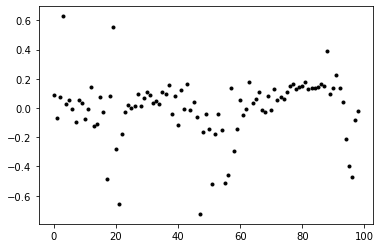

In [786]:
# roi_water
data = index_area(detrended, 'NDVI', roi_water)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

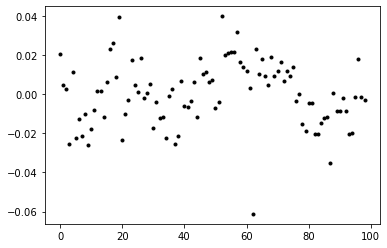

In [787]:
# roi_building
data = index_area(detrended, 'NDVI', roi_building)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

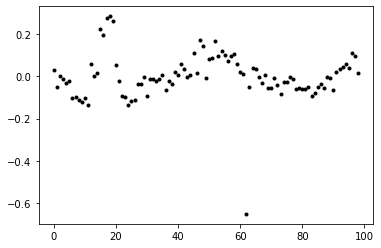

In [788]:
# roi_vegetation
data = index_area(detrended, 'NDVI', roi_vegetation)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

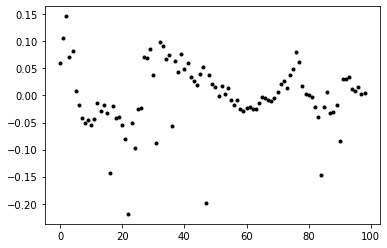

In [789]:
# roi_baresoil
data = index_area(detrended, 'NDVI', roi_baresoil)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

Harmonic regression

In [682]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

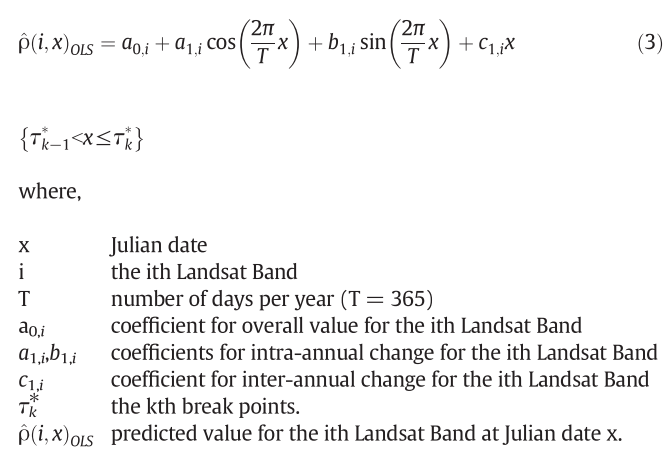

In [683]:
firsta = collection.first()
print(firsta.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI', 't', 'constant']


In [791]:
# Add harmonic terms as new image bands.

def func_cow(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_cow)

harmonicTrend = harmonicLandsat.select(harmonicIndependents.add(dependent)) \
    .reduce(ee.Reducer.linearRegression(
    **{
    'numX': harmonicIndependents.length(),
    'numY': 1
    }))

In [792]:
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([harmonicIndependents])

# coefficient of time t (a*x), constant (b), c*cos(2*pi*t), d*sin(2*pi*t)
Map = geemap.Map()
Map.centerObject(Area_Nice)
### constant:
# mean NDVI over time # white = strong vegetation
# dark pixels = no vegetation
vis_params_c = {'bands': ['constant'], 'min': 0, 'max': 1,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(harmonicTrendCoefficients),vis_params_c,'constant')
### t:
# time: white = NDVI growing, black = NDVI going down
vis_params_t = {'bands': ['t'], 'min': -0.05, 'max': 0.05,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(harmonicTrendCoefficients),vis_params_t,'time coefficient')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [793]:
# Compute fitted values.

def func_qam(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_qam)

In [794]:
def harmonic_index_area(detrended,index, roi):
    index_series = detrended.filterBounds(roi).select(['fitted',index]).toBands()
    index_values = index_series.reduceRegion(ee.Reducer.mean(), roi , 30)
    data = index_values.getInfo() # dictionary with keys = timestamps, values = NDVI
    return data

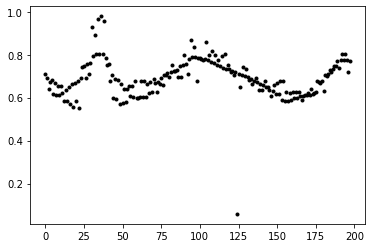

In [795]:
# roi_vegetation
data = fitted_index_area(fittedHarmonic, 'NDVI', roi_vegetation)
plt.plot(list(data.values()),  '.', color='black')


plt.show()

In [796]:
import datetime
start = datetime.date(2017, 3, 28)
print(start)
end = datetime.date(2019, 12, 28)
print(end)

date_key = list(data.keys())[0][:8]
year, month, day = int(date_key[:4]),int(date_key[4:6]),int(date_key[6:])
print(year,month,day)
date = datetime.date(year,month,day)
print(date)

2017-03-28
2019-12-28
2017 3 28
2017-03-28


In [797]:
new_data = {}

for k in list(data.keys()):
    date_key = k[:8]
    year, month, day = int(date_key[:4]),int(date_key[4:6]),int(date_key[6:])
    date = datetime.date(year,month,day)
    new_data[date] = data[k]

print(list(new_data.keys())[-1])

2019-12-28


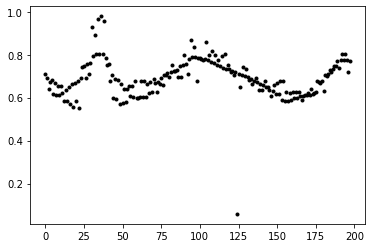

In [804]:
plt.plot(range(len(list(data.keys()))), list(data.values()),  '.', color='black')

# plt.gca().set_xbound(start, end)
plt.show()

In [547]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','NDVI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['NDVI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))
#

In [548]:
# Compute phase and amplitude.
phase_ndvi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NDVI")

amplitude_ndvi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NDVI")

# Compute the mean NDVI.
meanNdvi= collection.select('NDVI').mean().rename("VAL_NDVI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_ndvi,      # hue
    amplitude_ndvi,  # saturation (difference from white)
    meanNdvi    # value (difference from black)
    ]).hsvToRgb()

Add to map

In [549]:
Map.addLayer(rgb, {}, 'phase_ndvi (hue), amplitude_ndvi (sat), ndvi (val')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

### NMDI

The Normalized Multi-band Drought Index (NMDI) is used for monitoring soil and vegetation moisture from space.

In [742]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('NMDI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [743]:
# Compute a de-trended series.
def func_dcf(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_dcf)

Plot the detrended results.

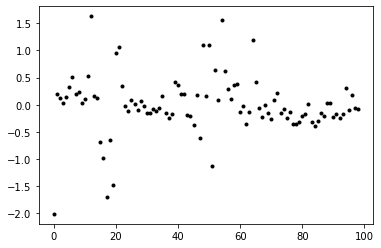

In [744]:
# roi_water
data = index_area(detrended, 'NMDI',roi_water)
# plt.plot(list(data.values()))
plt.plot(list(data.values()), '.', color='black')

plt.show()

In [745]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

Harmonic regression.

In [746]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [747]:
# Add harmonic terms as new image bands.

def func_mwh(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_mwh)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [748]:
# Compute fitted values.

def func_hoj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_hoj)

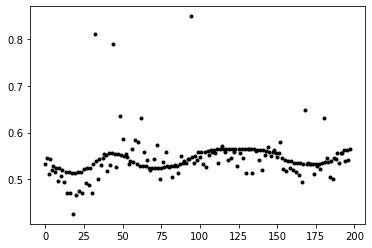

In [749]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'NMDI',roi_baresoil)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

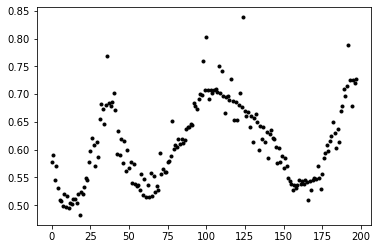

In [750]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'NMDI',roi_vegetation)
plt.plot(list(data.values()),  '.', color='black')

plt.show()

In [558]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','NMDI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['NMDI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))

In [561]:
# Compute phase and amplitude.
phase_nmdi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NMDI")

amplitude_nmdi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NMDI")

# Compute the mean NDVI.
meanNmdi= collection.select('NMDI').mean().rename("VAL_NMDI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_nmdi,      # hue
    amplitude_nmdi,  # saturation (difference from white)
    meanNmdi    # value (difference from black)
]).hsvToRgb()

Add to map

In [562]:
Map.addLayer(rgb, {}, 'phase_nmdi (hue), amplitude_nmdi (sat), nmdi (val')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

### NDBI

The Normalized Difference Built-up Index (NDBI) uses the NIR and SWIR bands to emphasize manufactured built-up areas.

In [751]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('NDBI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [752]:
# Compute a de-trended series.

def func_szc(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_szc)

Detrended chart.

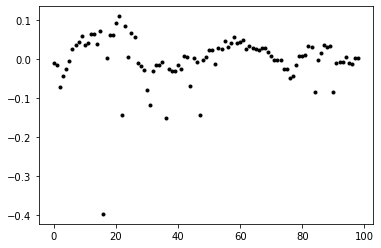

In [754]:
# roi_baresoil
data = index_area(detrended, 'NDBI',roi_baresoil)
plt.plot(list(data.values()),'.', color='black')

plt.show()

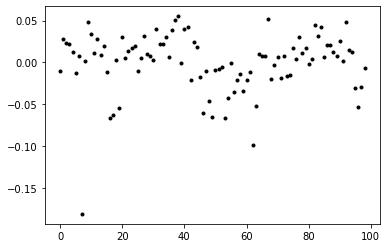

In [755]:
# roi_building
data = index_area(detrended, 'NDBI',roi_building)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [567]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

In [756]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [757]:
# Add harmonic terms as new image bands.

def func_ynp(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_ynp)

harmonicTrend = harmonicLandsat \
    .select(harmonicIndependents.add(dependent)) \
    .reduce(ee.Reducer.linearRegression(
        **{
            'numX': harmonicIndependents.length(),
            'numY': 1
        }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([harmonicIndependents])

In [758]:
# Compute fitted values.

def func_coj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_coj)

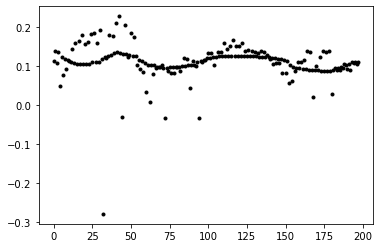

In [759]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'NDBI',roi_baresoil)
plt.plot(list(data.values()),'.', color='black')

plt.show()

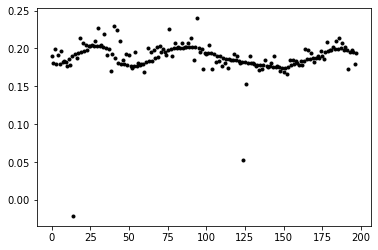

In [760]:
# roi_building
data = harmonic_index_area(fittedHarmonic, 'NDBI',roi_building)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','NDBI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['NDBI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))

In [572]:
# Compute phase and amplitude.
phase_ndbi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NDBI")

amplitude_ndbi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NDBI")

# Compute the mean NDVI.
meanNdbi= collection.select('NDBI').mean().rename("VAL_NDBI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
        phase_ndbi,      # hue
        amplitude_ndbi,  # saturation (difference from white)
        meanNdbi    # value (difference from black)
        ]).hsvToRgb()

Add to map

In [573]:
Map.addLayer(rgb, {}, 'phase_nmdi (hue), amplitude_nmdi (sat), nmdi (val')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

### BSI

Bare Soil Index (BSI) is a numerical indicator that combines blue, red, near infrared and short wave infrared spectral bands to capture soil variations.

In [761]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('BSI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [762]:
# Compute a de-trended series.

def func_hzu(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_hzu)

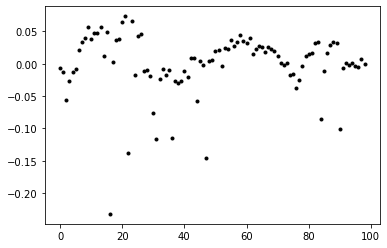

In [763]:
# roi_baresoil
data = index_area(detrended, 'BSI',roi_baresoil)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [764]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

In [765]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [766]:
# Add harmonic terms as new image bands.

def func_knr(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_knr)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [767]:
# Compute fitted values.

def func_fyi(image):
        return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_fyi)

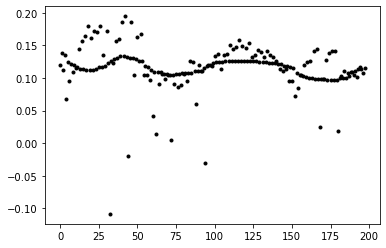

In [768]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'BSI',roi_baresoil)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [769]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','BSI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['BSI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))
#

In [770]:
# Compute phase and amplitude.
phase_bsi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_BSI")

amplitude_bsi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_BSI")

# Compute the mean BSI.
meanBsi= collection.select('BSI').mean().rename("VAL_BSI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_bsi,      # hue
    amplitude_bsi,  # saturation (difference from white)
    meanBsi    # value (difference from black)
    ]).hsvToRgb()

Add to the map

In [584]:
Map.addLayer(rgb, {}, 'phase_bsi (hue), amplitude_bsi (sat), bsi (val)')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

### GRVI

Green and Red ratio Vegetation Index

In [771]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('GRVI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [772]:
# Compute a de-trended series.

def func_rwe(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_rwe)

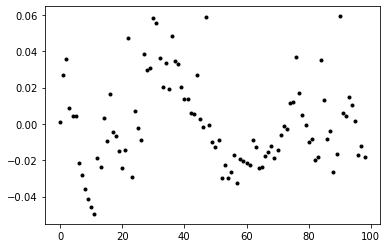

In [773]:
# roi_baresoil
data = index_area(detrended, 'GRVI',roi_baresoil)
plt.plot(list(data.values()),'.', color='black')

plt.show()

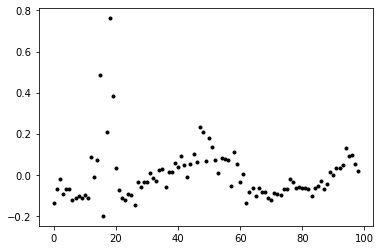

In [774]:
# roi_vegetation
data = index_area(detrended, 'GRVI',roi_vegetation)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [775]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [776]:
# Add harmonic terms as new image bands.

def func_sze(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_sze)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [777]:
# Compute fitted values.

def func_kuj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_kuj)

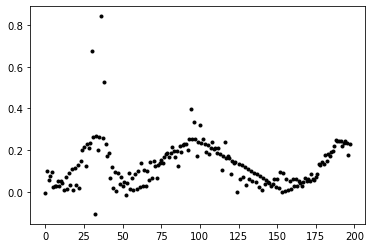

In [778]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'GRVI',roi_vegetation)
plt.plot(list(data.values()),'.', color='black')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','GRVI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['GRVI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))
#

In [593]:
# Compute phase and amplitude.
phase_grvi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_GRVI")

amplitude_grvi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_GRVI")

# Compute the mean GRVI.
meanGrvi= collection.select('GRVI').mean().rename("VAL_GRVI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_grvi,      # hue
    amplitude_grvi,  # saturation (difference from white)
    meanGrvi    # value (difference from black)
    ]).hsvToRgb()

Add layer to map

In [594]:
Map.addLayer(rgb, {}, 'phase_grvi (hue), amplitude_grvi (sat), grvi (val)')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

## Lag function

This function is not used.

In [ ]:
# use only in case of joining 2 collections of different times
def lag(leftCollection, rightCollection, lagDays):
    filter = ee.Filter.And(
        ee.Filter.maxDifference({
            'difference': 1000 * 60 * 60 * 24 * lagDays,
            'leftField': 'system:time_start',
            'rightField': 'system:time_start'
        }),
        ee.Filter.greaterThan({
            'leftField': 'system:time_start',
            'rightField': 'system:time_start'
        }))
    return ee.Join.saveAll({
        'matchesKey': 'images',
        'measureKey': 'delta_t',
        'ordering': 'system:time_start',
        'ascending': False, # Sort reverse chronologically
    }).apply({
        'primary': leftCollection,
        'secondary': rightCollection,
        'condition': filter
    })

## Select and extract bands

In [595]:
print(OutBands)
final_bands= compclip.select(OutBands)
# print(final_bands.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI_MAX', 'NDVI', 'NDVI_STD', 'NMDI', 'NMDI_MAX', 'NMDI_STD', 'NDBI', 'NDBI_MAX', 'NDBI_STD', 'BSI', 'BSI_MAX', 'BSI_STD', 'EVI', 'EVI_MAX', 'EVI_STD', 'GRVI', 'GRVI_MAX', 'GRVI_STD', 'MNDWI', 'MNDWI_MAX', 'MNDWI_STD', 'SMMI', 'SMMI_MAX', 'SMMI_STD']


In [596]:
#Visualization of the final dataset using RGB and CIR
Map = geemap.Map()
Map.centerObject(Area_Nice)
Map.addLayer(final_bands, {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'],}, 'RGB')
Map.addLayer(final_bands, {'min': 0.0, 'max': 0.3, 'bands': ['B8', 'B4', 'B3'],}, 'CIR')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [597]:
#Add the index statistics to the median bands and clip the dataset with the ROI
compclip = band_median.addBands(ndvimax).addBands(ndvimean).addBands(ndvistd) \
    .addBands(nmdimax).addBands(nmdimean).addBands(nmdistd) \
    .addBands(ndbimax).addBands(ndbimean).addBands(ndbistd) \
    .addBands(phase_ndvi).addBands(amplitude_ndvi).addBands(meanNdvi) \
    .addBands(phase_nmdi).addBands(amplitude_nmdi).addBands(meanNmdi) \
    .addBands(phase_ndbi).addBands(amplitude_ndbi).addBands(meanNdbi) \
    .addBands(bsimax).addBands(bsimean).addBands(bsistd) \
    .addBands(evimax).addBands(evimean).addBands(evistd) \
    .addBands(grvimax).addBands(grvimean).addBands(grvistd) \
    .addBands(mndwimax).addBands(mndwimean).addBands(mndwistd) \
    .addBands(smmimax).addBands(smmimean).addBands(smmistd) \
    .addBands(phase_bsi).addBands(amplitude_bsi).addBands(meanBsi) \
    .addBands(phase_grvi).addBands(amplitude_grvi).addBands(meanGrvi) \
    .clip(Area_Nice)


print(compclip.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI_MAX', 'NDVI', 'NDVI_STD', 'NMDI_MAX', 'NMDI', 'NMDI_STD', 'NDBI_MAX', 'NDBI', 'NDBI_STD', 'HUE_NDVI', 'SAT_NDVI', 'VAL_NDVI', 'HUE_NMDI', 'SAT_NMDI', 'VAL_NMDI', 'HUE_NDBI', 'SAT_NDBI', 'VAL_NDBI', 'BSI_MAX', 'BSI', 'BSI_STD', 'EVI_MAX', 'EVI', 'EVI_STD', 'GRVI_MAX', 'GRVI', 'GRVI_STD', 'MNDWI_MAX', 'MNDWI', 'MNDWI_STD', 'SMMI_MAX', 'SMMI', 'SMMI_STD', 'HUE_BSI', 'SAT_BSI', 'VAL_BSI', 'HUE_GRVI', 'SAT_GRVI', 'VAL_GRVI']


In [ ]:
OutBands  = ["B5","B7"#,"B6","B8A","B4","B11"
    ,"B8","B12"
    #,"NDVI_MAX","NDVI_STD"
    ,"NDBI_MAX","NDBI_STD"#,"HUE_NDVI","SAT_NDVI","NDVI"#,"VAL_NDVI",
    ,"NDBI","B2"#,"B3"#,"VAL_NDBI","HUE_NDBI","SAT_NDBI"
    #,"NMDI","NMDI_MAX","NMDI_STD","HUE_NMDI","SAT_NMDI","VAL_NMDI"
    #,"BSI","VAL_BSI"
    #,"BSI_STD","BSI_MAX","HUE_BSI","SAT_BSI"
    #,"EVI","EVI_MAX","EVI_STD"
    #,"GRVI","GRVI_STD","HUE_GRVI","GRVI_MAX","SAT_GRVI"//,"VAL_GRVI"
    #,"MNDWI","MNDWI_MAX","MNDWI_STD","SMMI","SMMI_MAX","SMMI_STD"
    ];

In [599]:
OutBands  = ["B5","B7","B6","B8A","B4","B11"
    ,"B8","B12"
    ,"NDVI_MAX","NDVI_STD"
    ,"NDBI_MAX","NDBI_STD","HUE_NDVI","SAT_NDVI","NDVI","VAL_NDVI"
    ,"NDBI","B2","B3","VAL_NDBI","HUE_NDBI","SAT_NDBI"
    ,"NMDI","NMDI_MAX","NMDI_STD","HUE_NMDI","SAT_NMDI","VAL_NMDI"
    ,"BSI","VAL_BSI"
    ,"BSI_STD","BSI_MAX","HUE_BSI","SAT_BSI"
    ,"EVI","EVI_MAX","EVI_STD"
    ,"GRVI","GRVI_STD","HUE_GRVI","GRVI_MAX","SAT_GRVI","VAL_GRVI"
    ,"MNDWI","MNDWI_MAX","MNDWI_STD","SMMI","SMMI_MAX","SMMI_STD"
    ];

Export regions

In [600]:
# split area in 4 zones
roi1 = ee.Geometry.Polygon(
        [[[6.642465422021031,43.53595758052378],[7.076425382958531,43.53595758052378],[7.076425382958531,43.87844627034738],[6.642465422021031,43.87844627034738],[6.642465422021031,43.53595758052378],]])
roi2  = ee.Geometry.Polygon(
        [[[6.719025509208998,43.87688879625747],[7.076081173271498,43.87688879625747],[7.076081173271498,44.36389752233614],[6.719025509208998,44.36389752233614],[6.719025509208998,43.87688879625747],]])
roi3  = ee.Geometry.Polygon(
        [[[7.073694731019966,43.53711239202778],[7.447229887269966,43.53711239202778],[7.447229887269966,43.879099567521784],[7.073694731019966,43.879099567521784],[7.073694731019966,43.53711239202778],]])
roi4 = ee.Geometry.Polygon(
        [[[7.070427585392207,43.87615487031022],[7.457695651798457,43.87615487031022],[7.457695651798457,44.193072642068195],[7.070427585392207,44.193072642068195],[7.070427585392207,43.87615487031022],]])

In [601]:
#Export the images to an Earth Engine asset

# export compclip or final_bands?

task1 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi1,
    scale=10,
    description='07-25_DATASET_COMPOSITION_Nice_allBands_T1',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T1')

task1.start()

task2 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi2,
    scale=10,
    description='07-25_DATASET_COMPOSITION_Nice_allBands_T2',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T2')

task2.start()

task3 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi3,
    scale=10,
    description='07-25_DATASET_COMPOSITION_Nice_allBands_T3',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T3')

task3.start()

task4 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi4,
    scale=10,
    description='07-25_DATASET_COMPOSITION_Nice_allBands_T4',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T4')

task4.start()

In [ ]:
# too large
# export compclip or final_bands ?
filename = '/home/scuypers/GEE/outputs/05-23_DATASET_COMPOSITION_Nice_OO_9_T1.tif'
geemap.ee_export_image(
    compclip, filename=filename, scale=10, region=roi1, file_per_band=False
)

# Classification

## Preparing data

In [602]:
# import assets
training = ee.FeatureCollection('users/suzannacuypers/EARSeL/trainingData_Nice_new')
validation = ee.FeatureCollection('users/suzannacuypers/EARSeL/validationData_Nice_new')

In [603]:
# loading data
newfc = training
valpnts = validation

# remap labels
newfc = newfc.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9], 'b1');
valpnts = valpnts.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9], 'b1');

scale = 20

Loading HR data

In [604]:
HR_data = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Ortho").mosaic()
print(type(HR_data))

#nomalizing the HR data
RGB_MIN = 0
RGB_MAX = 255
normalized = HR_data.select(['b1', 'b2', 'b3']).unitScale(RGB_MIN, RGB_MAX)
print(type(normalized))

<class 'ee.image.Image'>
<class 'ee.image.Image'>


Loading Composite images

In [605]:
image1 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T1')
image2 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T2')
image3 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T3')
image4 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T4')

print(image1.bandNames().getInfo())

table1 = ee.FeatureCollection('users/andreanascetti/IEEE/Nice_Tiles') # all tile shapes of GT data
# table2 = Area_Nice # ??? # Table from users/andreanascetti/IEEE/Nice_Tiles

S2_data = ee.ImageCollection([image1,image2,image3,image4]).mosaic().clip(table1)
dataset = normalized.addBands(S2_data)
print(dataset.bandNames().getInfo())

['B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']


In [607]:
# add layers to map
Map = geemap.Map()

Map.centerObject(table1)

Map.addLayer(image1,{},'image1') # one imported image
# Map.addLayer(table1,{},'area polygons')
Map.addLayer(dataset,{},'normalized RGB + S2 tiles')

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Loading ground truth labels

In [608]:
groundTruth = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")

Adding data to the map

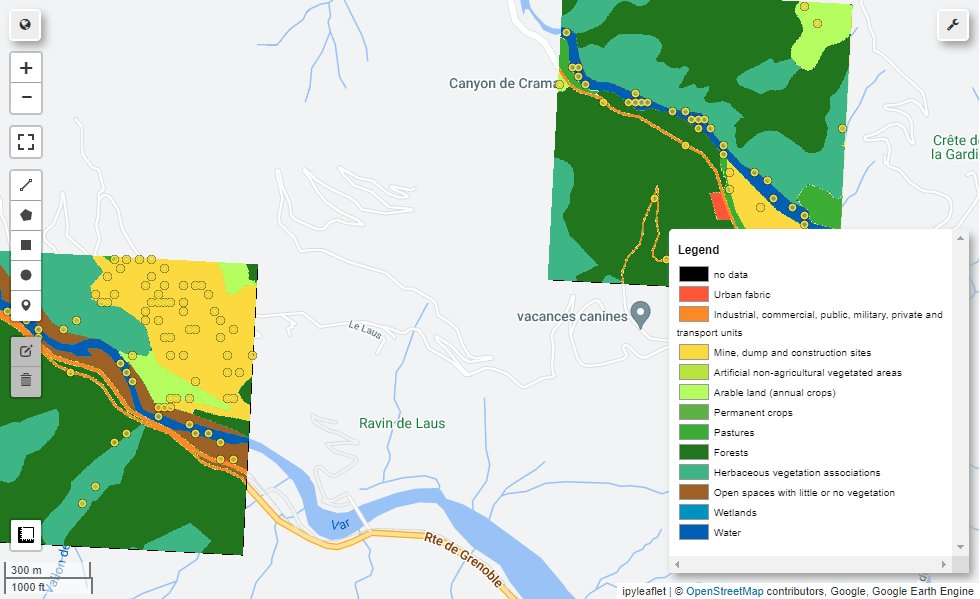

In [609]:
palette = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
  '000000',
]

In [616]:
Map = geemap.Map()#center=(43.708, 7.228), zoom=10)

Map.centerObject(table1)

vis_params = {'color': 'f5e105ff'} # yellow

Map.addLayer(dataset, {'min': 0.0, 'max': 1.0, 'bands': ['b1', 'b2', 'b3'], }, 'RGB') # RGB + S2 data
Map.addLayer(groundTruth.mosaic(),{'min':0, 'max':15, 'palette':palette},"Labels_Nice")
Map.addLayer(newfc,vis_params,'Training points')

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Add legend if desired

In [80]:
legend_dict = {
  'no data':'000000',
  'Urban fabric':'FF5733', #(0)  
  'Industrial, commercial, public, military, private and transport units':'F98A04', #(1)  
  'Mine, dump and construction sites':'FBDB10', #(2)  
  'Artificial non-agricultural vegetated areas':'B7E603', #(3)  
  'Arable land (annual crops)':'B6FF45', #(4)  
  'Permanent crops':'5FB331', #(5)  
  'Pastures':'3FAF17', #(6)  
  #'complex and mixed...':'FCE5CD', #()
  #'orchards at the fringe':'C6ECB6', #()
  'Forests':'237605', #(7)  
  'Herbaceous vegetation associations':'43B680', #(8)  
  'Open spaces with little or no vegetation':'9B621A', #(9)  
  'Wetlands':'0691C3', #(10)  
  'Water':'085CB8', #(11)  
  #'Clouds & Shadow':'000000',
}
Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

In [611]:
#To improve the amount of supervised information, a buffer with a fixed radius (10 m) is created around each point.
def buffer(feature):
    return feature.buffer(10)

newfc = newfc.map(buffer)

## Define the classifier

In [612]:
#if you want use RandomForest (classifier_alg= "RF") else use SVM (classifier_alg= "SVM")
classifier_alg = "RF"

In [ ]:
## original code 

'''
//If you decided to use the SVM algorithm it's mandatory the normalization of the input bands
if(classifier_alg =="SVM"){
  var image = ee.Image(dataset);
  // calculate the min and max value of an image
  var minMax = image.reduceRegion({
    reducer: ee.Reducer.minMax(),
    geometry: roi,
    scale: scale,
    maxPixels: 10e16,
  }); 
// use unit scale to normalize the pixel values
var dataset = ee.ImageCollection.fromImages(
  image.bandNames().map(function(name){
    name = ee.String(name);
    var band = image.select(name);
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(image.bandNames());
}
'''

In [613]:
#If you decided to use the SVM algorithm it's mandatory to normalize the input bands

def func_yvi(name):
    name = ee.String(name)
    band = image.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))

if classifier_alg == "SVM":
    image = ee.Image(dataset)
    # calculate the min and max value of an image
    minMax = image.reduceRegion(
        **{
            'reducer': ee.Reducer.minMax(),
            'geometry': roi,
            'scale': scale,
            'maxPixels': 10e16,
        })
    # use unit scale to normalize the pixel values
    dataset = ee.ImageCollection.fromImages(
        image.bandNames().map(func_yvi)).toBands().rename(image.bandNames()) # go back to original band names

## Object Based Approach

### SNIC

In [621]:
# Segmentation using a SNIC approach based on the dataset previosly generated
size_segmentation = 10 # influences cluster size
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation)

# paper: compactness = 0, connectivity = 8, and neighborhood size = 256
snic = ee.Algorithms.Image.Segmentation.SNIC(
    **{
        'image': dataset,#.select('b1','b2','b3'),
        'compactness': 0, # influences the cluster shape (larger values produce more compact clusters)
        'connectivity': 8, # (4 or 8) defines if consider a Rook’s or Queen’s contiguity to merge adjacent clusters
        'neighborhoodSize': 256, # to avoid tile boundary artifacts
        'seeds': seeds
    })
print(snic.bandNames().getInfo())

clusters_snic = snic.select("clusters")
crs = clusters_snic.projection().getInfo()['crs']
print(crs) # EPSG:4326

# SNIC outputs are variable depending on the visualization scale.
# Thus it is necessary to fix a proper output scale of clusters through the “reproject” function (S2 = 10)
scale = 10
clusters_snic = clusters_snic.reproject (**{'crs': crs, 'scale': scale})

['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
['clusters', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']
EPSG:4326


The result of snic are not just clusters, but also the mean values per band per cluster. The one-the-fly computation calculates the results at the zoom scale. This is and RGB image of b1_mean, b2_mean, and b3_mean:

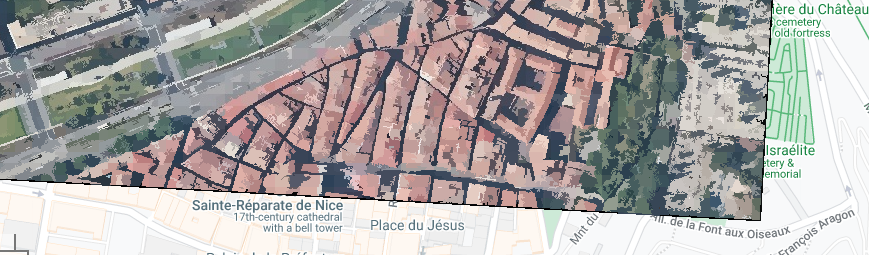

Visualization of snic band NDBI_MAX_mean: per snic cluster the mean of the NDBI_MAX values (of the image collection):

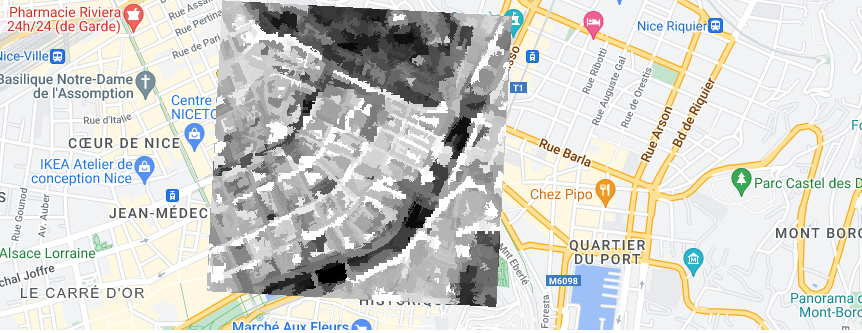

In [620]:
Map.addLayer(snic,{'bands':'NDBI_MAX_mean','min': -0.1, 'max': 0.50},'snic')
# Map.addLayer(clusters_snic.randomVisualizer(), {}, 'clusters')
Map

Map(bottom=6119882.0, center=[43.70514268007117, 7.276103496551515], controls=(WidgetControl(options=['positio…

In [623]:
# export snic results
name_asset = 'users/suzannacuypers/EARSeL/snic_NDBI_T1'

task = ee.batch.Export.image.toAsset(
    image=snic,
    region = roi1,
    scale=10,
    description='snic NDBI T1',
    assetId=name_asset)

task.start()
print('task finished')

task finished


### GLCM

In [624]:
#Create and rescale a grayscale image for GLCM
# paper: Gray = (0.3 × NIR) + (0.59 × RED) + (0.11 × GREEN)
print(type(dataset))
gray = dataset.expression(
      '(0.11 * B) + (0.3 * R) + (0.59 * G)', {
      'B': dataset.select('b3'),
      'R': dataset.select('b1'),
      'G': dataset.select('b2')
}).rename('gray')
print(type(gray))

# the glcmTexture size (in pixel) can be adjusted considering the spatial resolution and the object textural characteristics

glcm = gray.unitScale(0, 0.30).multiply(100).toInt().glcmTexture(**{'size': 2})
print(type(glcm))
print(glcm.bandNames().getInfo()) 

# ['gray_asm', 'gray_contrast', 'gray_corr', 'gray_var', 'gray_idm',
#'gray_savg', 'gray_svar', 'gray_sent', 'gray_ent', 'gray_dvar', 
#'gray_dent', 'gray_imcorr1', 'gray_imcorr2', 'gray_maxcorr', 
#'gray_diss', 'gray_inertia', 'gray_shade', 'gray_prom']

<class 'ee.image.Image'>
<class 'ee.image.Image'>
<class 'ee.image.Image'>
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_var', 'gray_idm', 'gray_savg', 'gray_svar', 'gray_sent', 'gray_ent', 'gray_dvar', 'gray_dent', 'gray_imcorr1', 'gray_imcorr2', 'gray_maxcorr', 'gray_diss', 'gray_inertia', 'gray_shade', 'gray_prom']


The selected GLCM metrics:

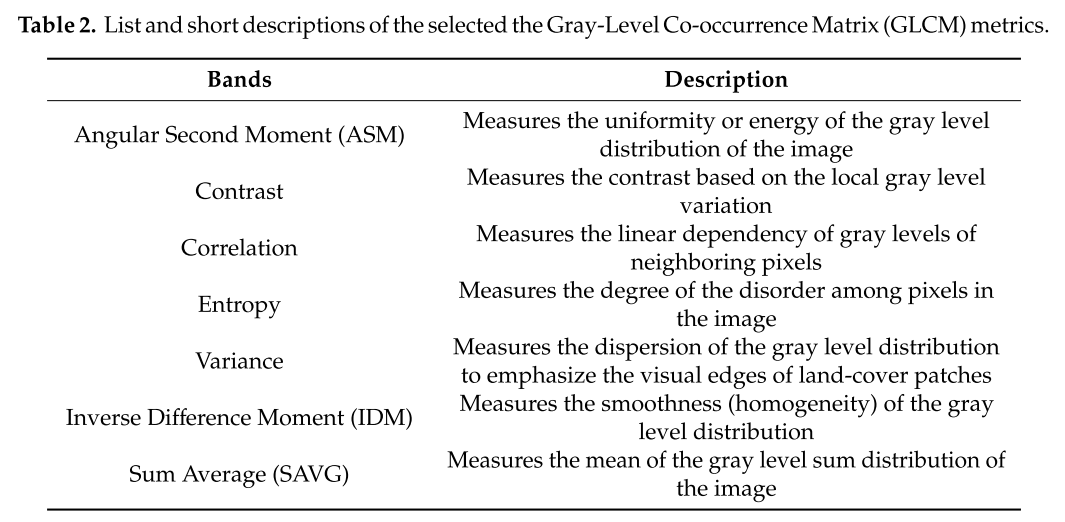

In [625]:
# Define the GLCM indices used in input for the PCA
glcm_bands= ["gray_asm","gray_contrast","gray_corr","gray_ent","gray_var","gray_idm","gray_savg"]

#--- Before the PCA the glcm bands are scaled
image = glcm.select(glcm_bands)
print(type(image))


<class 'ee.image.Image'>


In [627]:
glcm = image
# if not performing PCA, skip the next step

In [152]:
# calculate the min and max value of an image
minMax = image.reduceRegion(
    **{
        'reducer': ee.Reducer.minMax(),
        'geometry': Area_Nice,
        'scale': scale,
        'maxPixels': 10e16,
        'tileScale':8
    })

def func_ehv(name):
    name = ee.String(name)
    band = image.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))

glcm = ee.ImageCollection.fromImages(image.bandNames().map(func_ehv)).toBands().rename(image.bandNames())
# glcm = image.bandNames().map(func_ehv).toBands().rename(image.bandNames())
print(type(glcm))
print(glcm.bandNames().getInfo())

<class 'ee.image.Image'>
<class 'ee.image.Image'>
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


### PCA

For now, we skip PCA and add the GLCM bands not normalized to the snic bands.


Then, after a proper standardization, a PCA of the most relevant 7 GLCM metric (Table 2), selected
according to Hall-Beyer et al., is applied to derive a single representative band (the first PC) which generally contains the vast majority of the textural information.

In [131]:
# The code relating to the PCA was adapted from the GEE documentation  https:#developers.google.com/earth-engine/guides/arrays_eigen_analysis

# Get some information about the input to be used later.
scale = 20 #glcm.projection().nominalScale()
print("Nominal Scale", scale)
bandNames = glcm.bandNames()
print(bandNames.getInfo()) # ['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']

# Mean center the data to enable a faster covariance reducer and an SD stretch of the principal components.
meanDict = glcm.reduceRegion(
    **{'reducer': ee.Reducer.mean(),
       'geometry': Area_Nice,
       'scale': scale,
       'maxPixels': 10e16,
       'tileScale':8
      })
means = ee.Image.constant(meanDict.values(bandNames)) # image with all pixels same value = mean of the band over the area
centered = glcm.subtract(means) # center distribution -> mean = 0 # for computation of PCA
print(type(centered))

Nominal Scale 20
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']
<class 'ee.image.Image'>


PCA helper functions

In [108]:
# This helper function returns a list of new band names.
def getNewBandNames(prefix):
    seq = ee.List.sequence(1, bandNames.length())
    def func_rzr(b):
        return ee.String(prefix).cat(ee.Number(b).int())
    return seq.map(func_rzr)

In [109]:
# This function accepts mean centered imagery, a scale and a region in which to perform the analysis.
# It returns the Principal Components (PC) in the region as a new image.

def getPrincipalComponents(centered, scale, region):
    # Collapse the bands of the image into a 1D array per pixel.
    arrays = centered.toArray()
    # Compute the covariance of the bands within the region.
    covar = arrays.reduceRegion(
        **{'reducer': ee.Reducer.centeredCovariance(),
           'geometry': region,
           'scale': scale,
           'maxPixels': 10e16,
           'tileScale':8
          })

    # Get the 'array' covariance result and cast to an array.
    # This represents the band-to-band covariance within the region.
    covarArray = ee.Array(covar.get('array'))

    # Perform an eigen analysis and slice apart the values and vectors.
    eigens = covarArray.eigen()

    # This is a P-length vector of Eigenvalues.
    eigenValues = eigens.slice(1, 0, 1)
    # This is a PxP matrix with eigenvectors in rows.
    eigenVectors = eigens.slice(1, 1)

    # Convert the array image to 2D arrays for matrix computations.
    arrayImage = arrays.toArray(1)

    # Left multiply the image array by the matrix of eigenvectors.
    principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

    # Turn the square roots of the Eigenvalues into a P-band image.
    sdImage = ee.Image(eigenValues.sqrt()) \
    .arrayProject([0]).arrayFlatten([getNewBandNames('sd')])

    # Turn the PCs into a P-band image, normalized by SD.
    return principalComponents \
        .arrayProject([0]) \
        .arrayFlatten([getNewBandNames('pc')]) \
        .divide(sdImage)

In [216]:
print(type(centered))
pcImage = getPrincipalComponents(centered, scale, Area_Nice)
print(type(pcImage))

<class 'ee.image.Image'>
<class 'ee.image.Image'>


### Adding the PC1 object-averaged band to those extracted from SNIC

The average of PC1 is then calculated in a separate band for each object included in the SNIC “clusters” band. The PC1 object-averaged band is finally added to those extracted from the SNIC segmentation process.

In [ ]:
#Select the band "clusters" from the snic output fixed on its scale of 10 meters and add them to the PC1 taken from the PCA data.
# Calculate the mean for each segment with respect to the pixels in that cluster
print(clusters_snic.bandNames().getInfo())
print(type(clusters_snic))
print(type(pcImage))
# print(pcImage.bandNames().getInfo())

In [628]:
### add GLCM bands without performing PCA
new_feature = clusters_snic.addBands(glcm)#(pcImage.select("pc1"))
# print(new_feature.bandNames().getInfo())

# all GLCM bands should be reduced per cluster
new_feature_mean = new_feature.reduceConnectedComponents(
    **{
      'reducer': ee.Reducer.mean(),
      'labelBand': 'clusters'
    }) # mean of band per cluster

#Create a dataset with the new band used so far together with the band "clusters" and their new mean parameters
final_bands = new_feature_mean.addBands(snic) # snic band contains clusters and all mean values of other bands per cluster
print(snic.bandNames().getInfo())
print(type(final_bands))
print(final_bands.bandNames().getInfo())

#Define the training bands removing just the "clusters" bands
predictionBands  = final_bands.bandNames().remove("clusters")
print(type(predictionBands))
print(predictionBands.getInfo())

['clusters', 'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']
['clusters', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']
<class 'ee.image.Image'>
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg', 'clusters', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']
<class 'ee.ee_list.List'>
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']


In [ ]:
'''
//---- Normalize all data if you decide to use the SVM classifier
if (classifier_alg=="SVM"){
  
var minMax = final_bands.reduceRegion(**{
  reducer: ee.Reducer.minMax(),
  geometry: roi,
  scale: scale,
  maxPixels: 10e16,
  tileScale:8
});
'''

'''final_bands = ee.ImageCollection.fromImages(
    final_bands.bandNames().map(function(name){
        name = ee.String(name)
        band = final_bands.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(final_bands.bandNames())'''

def func_mgp(name):
    name = ee.String(name)
    band = final_bands.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))


final_bands = ee.ImageCollection.fromImages(final_bands.bandNames().map(func_mgp)).toBands().rename(final_bands.bandNames())

### Training the classifier

As generally performed, a band normalization of the input dataset was applied before applying the SVM classification. For the RF classifier, the number of trees was set to 50, while for the SVM a radial basis function kernel (RBF) was applied (with gamma = 1 and cost = 10).

In [245]:
# Classification using the classifier with the training bands called predictionBands
print(predictionBands.getInfo()) # list
print(final_bands.bandNames().getInfo()) # dataset

['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg', 'clusters', 'b1_mean', 'b2_mean', 'b3_mean', 'B5_mean', 'B7_mean', 'B8_mean', 'B12_mean', 'NDBI_MAX_mean', 'NDBI_STD_mean', 'NDBI_mean', 'B2_mean']


In [629]:
scale = 30
training_geobia = final_bands.select(predictionBands).sampleRegions(
    **{
      'collection': newfc,
      'properties': ['b1'],
      'scale': scale
      #'tileScale':8
})

In [630]:
#Training the classifier
if classifier_alg == "RF":
    classifier = ee.Classifier.smileRandomForest(50).train(**{
        'features':training_geobia,
        'classProperty':'b1',
        'inputProperties': predictionBands
    })

elif classifier_alg == "SVM":
    classifie = ee.Classifier.libsvm(**{
        'kernelType': 'RBF',
        'gamma': 15,
        'cost': 10
    })
    classifier = classifie.train(training_geobia, 'b1', predictionBands)

else:
    print("You need to set your classifier for the Object based approach")

print("Training finished")

Training finished


### Classifying

In [631]:
Map = geemap.Map()

vis_params = {'bands': ['b1_mean', 'b2_mean', 'b3_mean'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0, 'gamma': 1.0}

Map.addLayer(final_bands,{'bands': 'clusters'},'clusters')
Map.addLayer(final_bands,vis_params,'final bands')
Map.centerObject(Area_Nice)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [282]:
# draw feature on map for roi
roi_s = Map.user_roi 
print(roi.getInfo())

{'type': 'Polygon', 'coordinates': [[[7.319043, 43.725994], [7.321618, 43.725994], [7.321618, 43.727793], [7.319043, 43.727793], [7.319043, 43.725994]]]}


In [277]:
roi_c = ee.Geometry.Polygon([
    [7.319043, 43.725994], 
    [7.321618, 43.725994], 
    [7.321618, 43.727793], 
    [7.319043, 43.727793], 
    [7.319043, 43.725994]
])

In [316]:
classy_RF = final_bands.select(predictionBands).clip(roi_s).classify(classifier)

In [632]:
classy_RF = final_bands.select(predictionBands).classify(classifier)

In [636]:
print(type(classy_RF))

<class 'ee.image.Image'>


In [633]:
print(classy_RF.bandNames().getInfo())

EEException: Output of image computation is too large (1 bands for 21159991 pixels = 80.7 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.

Add classification layer to the map

In [634]:
# crs = classy_RF.projection().getInfo()['crs']
crs = classy_RF.projection()

classy_RF = classy_RF.reproject (**{'crs': crs, 'scale': scale})

# classy_RF = classy_RF.reproject ({'crs': classy_RF.projection(), 'scale': scale})
# print(classy_RF.bandNames().getInfo())

In [635]:
Map.addLayer(classy_RF,{},'classification')
Map

EEException: Output of image computation is too large (8 bands for 4652613 pixels = 142.0 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.

### Exporting the classification

In [327]:
# export classified image to asset per roi
# print(predictionBands.getInfo())
description = predictionBands.join(' ')
print(description.getInfo())

gray_asm gray_contrast gray_corr gray_ent gray_var gray_idm gray_savg b1_mean b2_mean b3_mean B5_mean B7_mean B8_mean B12_mean NDBI_MAX_mean NDBI_STD_mean NDBI_mean B2_mean


In [637]:
task1 = ee.batch.Export.image.toAsset(
    image=classy_RF,
    #region = roi1,
    scale=10,
    description='classy RF OO',
    assetId='users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI')

task1.start()

In [329]:
name_asset = 'users/suzannacuypers/EARSeL/classy_OO_RF_roi{}_GLCM_NDBI'.format('1')
task5 = ee.batch.Export.image.toAsset(
    image=classy_RF,
    region = roi1,
    scale=30,
    description='export classy_RF roi 1',
    assetId=name_asset)

task5.start()
print('task 5 finished')

name_asset = 'users/suzannacuypers/EARSeL/classy_OO_RF_roi{}_GLCM_NDBI'.format('2')
task6 = ee.batch.Export.image.toAsset(
    image=classy_RF,
    region = roi2,
    scale=30,
    description='export class_RF roi 2',
    assetId=name_asset)

task6.start()
print('task 6 finished')

task 5 finished
task 6 finished


In [310]:
Map.addLayer(classy_RF, {'min': 0, 'max': 9, 'palette': palette}, 'LULC GEOBIA APPROACH')

EEException: Output of image computation is too large (8 bands for 4652613 pixels = 142.0 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.

### Validation of Object-Oriented Approach

In [641]:
#Validation of the object-oriented approach
classifier_geobia = final_bands.select(predictionBands).sampleRegions(
    **{
        'collection': valpnts,
        'properties': ['b1'],
        'scale': scale,
        'tileScale':8
    })

classificazione = classifier_geobia.classify(classifier)

testAccuracy = classificazione.errorMatrix('b1', 'classification')

# print('GEOBIA approach_Test confusion matrix: ', testAccuracy.getInfo())
# print('GEOBIA APPROACH: Overall accuracy ', testAccuracy.accuracy())
# print(testAccuracy)

#Print the number of pixels for each class
analysis_image_sl = classy_RF.select("classification")

In [642]:
class1 =  analysis_image_sl.updateMask(analysis_image_sl.eq(1))
class2 =  analysis_image_sl.updateMask(analysis_image_sl.eq(2))
class3 =  analysis_image_sl.updateMask(analysis_image_sl.eq(3))
class4 =  analysis_image_sl.updateMask(analysis_image_sl.eq(4))
class5 =  analysis_image_sl.updateMask(analysis_image_sl.eq(5))
class6 =  analysis_image_sl.updateMask(analysis_image_sl.eq(6))
class7 =  analysis_image_sl.updateMask(analysis_image_sl.eq(7))
class10 =  analysis_image_sl.updateMask(analysis_image_sl.eq(10))
class11 =  analysis_image_sl.updateMask(analysis_image_sl.eq(11))
class12 =  analysis_image_sl.updateMask(analysis_image_sl.eq(12))
class13 =  analysis_image_sl.updateMask(analysis_image_sl.eq(13))
class14 =  analysis_image_sl.updateMask(analysis_image_sl.eq(14))

all_classes = class1.addBands(class2).addBands(class3).addBands(class4) \
          .addBands(class5).addBands(class6).addBands(class7).addBands(class10) \
          .addBands(class11).addBands(class12).addBands(class13).addBands(class14)

count_pixels = all_classes.reduceRegion(
    **{
        'reducer': ee.Reducer.count(),
        'geometry': roi,
        'scale':scale,
        'maxPixels': 1e16,
        'tileScale':8
    })

In [643]:
print(count_pixels, "GEOBIA APPROACH: pixels for each class")
#
exportCM = ee.Feature(None, {'CM': testAccuracy.array()})

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Relative importance histogram

In [ ]:
#Compute RF variable importance
dict = classifier.explain()
print("classifier information:", dict)
variableImportance = ee.Feature(None, ee.Dictionary(dict).get('importance'))

chart = ui.Chart.feature.byProperty(variableImportance).setChartType('ColumnChart').setOptions({
  'title': 'Random Forest Variable Importance',
  'legend': '{position': 'none'},
  'hAxis': '{title': 'Bands'},
  'vAxis': '{title': 'Importance'}
})
print(chart)

In [ ]:
# Export the FeatureCollection.
Export.table.toDrive({
  'collection': ee.FeatureCollection(exportCM),
  'description': '05-09_exportCM_Nice_OO_',
  'fileFormat': 'CSV'
})

In [ ]:
Map.addLayer(rgb, {}, 'phase_ndbi (hue), amplitude_ndbi (sat), ndbi (val)')
Map

In [ ]:
Map = geemap.Map()#center=(43.708, 7.228), zoom=10)

Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")
Map.centerObject(Nice)

palette = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
  '000000',
]

Map.addLayer(Nice.mosaic(),{'min':0, 'max':15, 'palette':palette},"Labels_Nice")

Map

## Pixel-Based Approach

In [149]:
#Selecting desired bands
bands= dataset.bandNames()
print(bands.getInfo())
# Get the predictors into the table and create a training dataset based on "b1" property
print(type(dataset))
training = dataset.select(bands).sampleRegions({
  'collection': newfc,
  'properties': ['b1'],
  'scale': scale
})

['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
<class 'ee.image.Image'>


EEException: Unrecognized argument type to convert to a FeatureCollection: {'collection': <ee.featurecollection.FeatureCollection object at 0x7f98f88dabe0>, 'properties': ['b1'], 'scale': 20}

In [ ]:
'''
//If you decided to use the SVM algorithm it's mandatory the normalization of the input bands
if(classifier_alg =="SVM"){
var image = ee.Image(dataset);
// calculate the min and max value of an image
var minMax = image.reduceRegion({
  reducer: ee.Reducer.minMax(),
  geometry: roi,
  scale: scale,
  maxPixels: 10e16,
}); 
// use unit scale to normalize the pixel values
var dataset = ee.ImageCollection.fromImages(
  image.bandNames().map(function(name){
    name = ee.String(name);
    var band = image.select(name);
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(image.bandNames());
}
'''

### Training the Classifier

In the PB classification stage, the image is quickly classified by a preliminary definition of the RF
classifier, or the SVM classifier, and the subsequent training phase. As generally performed, a band normalization of the input dataset was applied before applying the SVM classification. For the RF classifier, the number of trees was set to 50, while for the SVM a radial basis function kernel (RBF) was applied (with gamma = 1 and cost = 10). To clean up all the output and reduce the “salt and pepper” effect, a final morphological operation (based on a focal mode) is performed on the output classification

In [154]:
#if you want use RandomForest (classifier_alg= "RF") else use SVM (classifier_alg= "SVM")
classifier_alg = "RF"

In [330]:
#Training a Random Forest Classifier
if classifier_alg == "RF":
    classifier =  ee.Classifier.smileRandomForest(30).train(
        **{
        'features': training,
        'classProperty': 'b1',
        'inputProperties': bands
        })

elif classifier_alg == "SVM":
    classifi = ee.Classifier.libsvm(
        **{
        'kernelType': 'RBF',
        'gamma': 15,
        'cost': 20
        })
    classifier = classifi.train(training, 'b1', bands)

else:
    print("You need to set your classifier for the Pixel Based approach")


### Classifying

In [348]:
#Clip and filter the result of pixel' classification
print(bands.getInfo())
print(dataset.bandNames().getInfo())
classified = dataset.select(bands).classify(classifier).clip(Area_Nice).focal_mode()
print(classified.propertyNames().getInfo())
print(classified.bandNames().getInfo())

['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']


EEException: Property 'b2' is missing.

In [334]:
#Visualize the result
Map = geemap.Map()
Map.addLayer(classified, {'min': 0, 'max': 11}, 'LULC PIXEL APPROACH')
# Map.addLayer(classified, {'min': 0, 'max': 11, 'palette': palette}, 'LULC PIXEL APPROACH')
Map

EEException: Property 'b2' is missing.

In [ ]:
#Create the confusion matrix and calculate the overall accuracy on the training data
#print('RF error matrix_training: ', classifier.confusionMatrix())
#print('RF accuracy_training: ', classifier.confusionMatrix().accuracy())

### Validation of Pixel-Based Approach

In [ ]:
#Validation of the pixel-based approach
classifierTest = dataset.select(bands).sampleRegions({
    'collection': valpnts,
    'properties': ['b1'],
    'scale': scale
})
classified_test_RF = classifierTest.classify(classifier)
testAccuracy = classified_test_RF.errorMatrix('b1', 'classification')
#print('Pixel approach_Test confusion matrix: ', testAccuracy)
print('PIXEL APPROACH : Overall Accuracy ', testAccuracy.accuracy())
print(testAccuracy)

#Print the number of pixels for each class
analysis_image = classified.select("classification")

class_1 =  analysis_image.updateMask(analysis_image.eq(1))
class_2 =  analysis_image.updateMask(analysis_image.eq(2))
class_3 =  analysis_image.updateMask(analysis_image.eq(3))
class_4 =  analysis_image.updateMask(analysis_image.eq(4))
class_5 =  analysis_image.updateMask(analysis_image.eq(5))
class_6 =  analysis_image.updateMask(analysis_image.eq(6))
class_7 =  analysis_image.updateMask(analysis_image.eq(7))
class_10 =  analysis_image.updateMask(analysis_image.eq(8))
class_11 =  analysis_image.updateMask(analysis_image.eq(9))
class_12 =  analysis_image.updateMask(analysis_image.eq(10))
class_13 =  analysis_image.updateMask(analysis_image.eq(11))
class_14 =  analysis_image.updateMask(analysis_image.eq(0))

all = class_1.addBands(class_2).addBands(class_3).addBands(class_4) \
          .addBands(class_5).addBands(class_6).addBands(class_7).addBands(class_10) \
          .addBands(class_11).addBands(class_12).addBands(class_13).addBands(class_14)

count_pixels_one = all.reduceRegion({
  'reducer': ee.Reducer.count(),
  'geometry': roi,
  'scale': scale,
  'maxPixels': 1e11,

  })
print(count_pixels_one, "PIXEL APPROACH: pixels for each class")

#Compute RF variable importance
dict = classifier.explain()
print("classifier information:", dict)
variableImportance = ee.Feature(None, ee.Dictionary(dict).get('importance'))

chart = ui.Chart.feature.byProperty(variableImportance).setChartType('ColumnChart').setOptions({
  'title': 'Random Forest Variable Importance',
  'legend': '{position': 'none'},
  'hAxis': '{title': 'Bands'},
  'vAxis': '{title': 'Importance'}
})
print(chart)

exportCM = ee.Feature(None, {'CM': testAccuracy.array()})

# Export the FeatureCollection.
Export.table.toDrive({
  'collection': ee.FeatureCollection(exportCM),
  'description': 'exportCM_Nantes_PB_',
  'fileFormat': 'CSV'
})
#
Export.image.toDrive({
  'image': classified,
  'description': 'exportClassified_Nantes_PB_',
  'region': table2,
  'scale': 0.5,
  'crs': EPSG2154
})